## Imports

In [ ]:
import pickle
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input, Activation, Dense, Permute, Dropout
from tensorflow.keras.layers import add, dot, concatenate
from tensorflow.keras.layers import LSTM

## Single Supporting Fact story

In [15]:
with open("drive/MyDrive/data_science/memory_networks/train_qa.txt", "rb") as fp:   # Unpickling
    train_data =  pickle.load(fp)

with open("test_qa.txt", "rb") as fp:   # Unpickling
    test_data =  pickle.load(fp)

In [19]:
all_data = test_data + train_data


# Create a set that holds the vocab words
vocab = set()
for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

# Add no and yes as they are the vocabulary of answers
vocab.add('no')
vocab.add('yes')

# Extra space to hold a 0 for Keras's pad_sequences
vocab_len = len(vocab) + 1

# Max story length and max question length
max_story_len = max([len(data[0]) for data in all_data])
max_question_len = max([len(data[1]) for data in all_data])

# Reserve 0 for pad_sequences
vocab_size = len(vocab) + 1

In [21]:
# integer encode sequences of words
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [22]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    # Vectorize stories by storing them as sequences
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        y = np.zeros(len(word_index) + 1)
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)

    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [26]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [27]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

### Model

In [28]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # (samples, 32)

# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, None, 64)     2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
______________________________________________________________________________________________

In [29]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/120
313/313 [==============================] - 8s 17ms/step - loss: 0.8885 - accuracy: 0.4967 - val_loss: 0.6978 - val_accuracy: 0.4970
Epoch 2/120
313/313 [==============================] - 5s 16ms/step - loss: 0.7033 - accuracy: 0.5017 - val_loss: 0.6945 - val_accuracy: 0.4970
Epoch 3/120
313/313 [==============================] - 5s 16ms/step - loss: 0.6959 - accuracy: 0.5005 - val_loss: 0.6938 - val_accuracy: 0.4970
Epoch 4/120
313/313 [==============================] - 5s 16ms/step - loss: 0.6946 - accuracy: 0.5067 - val_loss: 0.6939 - val_accuracy: 0.4970
Epoch 5/120
313/313 [==============================] - 5s 15ms/step - loss: 0.6951 - accuracy: 0.4952 - val_loss: 0.6936 - val_accuracy: 0.4970
Epoch 6/120
313/313 [==============================] - 5s 16ms/step - loss: 0.6949 - accuracy: 0.4935 - val_loss: 0.6936 - val_accuracy: 0.5030
Epoch 7/120
313/313 [==============================] - 5s 15ms/step - loss: 0.6946 - accuracy: 0.4973 - val_loss: 0.6938 - val_accuracy:

In [35]:
filename = 'chatbot.h5'
model.save(filename)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


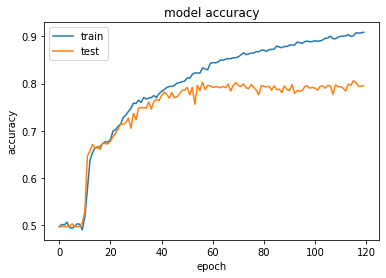

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()